# Preparing Dataset
json
incl
solvent
peak = [ppm,intensity]

Yppm batch X 100
Yintensity batch X 100

In [ ]:
InChi = ['1S/CH4/h1H4', '1S/H2O/h1H2', '1S/CH3.Li/h1H3', '1S/H4Si/h1H4', '1S/C3H4/c1-2-3-1/h1-2H,3H2', '1S/C3H5NO/c1-2-3(4)5/h2H,1H2,(H2,4,5)', '1S/C3H4O2/c1-2-3(4)5/h2H,1H2,(H,4,5)', '1S/C2H7NS/c3-1-2-4/h4H,1-3H2']
solvent = ['CCl4','CDCl3', 'benzene-d6', 'cyclohexane', 'neat', 'D2O', 'CDCl3', 'D2O']
frequency = [300, 399.65, 399.65, 300, 300, 89.56, 89.56]
peak = [[[69.60, 0.232, 1000]],
        [[631.05, 1.579, 1000]],
        [[-526.24, -1.316, 1000],
         [-534.29, -1.336, 29],
         [-534.90, -1.338, 25]],
        [[960.00, 3.200, 1000]],
        [[2118.9, 7.063, 995],
         [2117.19, 7.057, 997],
         [279.85, 0.933, 1000],
         [278.21, 0.927, 998]],
        [[583.06,6.511,25],
         [566.06,6.321,410],
         [563,6.287,444],
         [558.56,6.237,1000],
         [546,6.097,70],
         [540.25,6.033,46],
         [527.5,5.89,339],
         [523.06,5.841,242],
         [520.19,5.809,217],
         [515.75,5.759,194]],
       [[1073.93, 11.992, 489],
        [595.92,6.654,287],
        [592.50,   6.616,    300],
        [580.29,   6.480,    665],
        [576.87,   6.442,    813],
        [571.06,   6.377,     85],
        [563.02,   6.287,    516],
        [553.03,   6.175,   1000],
        [550.89,   6.152,    130],
        [539.18,   6.021,    829],
        [537.30,   6.000,    686],
        [535.77,   5.983,    846],
        [534.23,   5.966,     87],
        [529.19,   5.909,    356],
        [525.77,   5.871,    136]],
       [[445.88,   4.979,    970],
        [282.19,   3.151,     30],
        [278.19,   3.107,    321],
        [276.38,   3.086,    322],
        [271.88,   3.036,   474],
        [269.75,   3.012,   1000],
        [267.38,   2.986,    199],
        [264.19,   2.950,    846],
        [263.38,   2.941,    860],
        [259.63,   2.899,    124],
        [259.06,   2.893,    119],
        [258.00,   2.881,    103],
        [257.06,   2.871,     95],
        [256.81,  2.868 ,    95],
        [256.31,   2.862,     92],
        [256.00,   2.859,     88],
        [255.31,   2.851,     90],
        [255.00,   2.848,     91],
        [254.75,   2.845,     91],
        [248.00,   2.770,    689],
        [241.63,   2.698,    747],
        [235.13,   2.626,    268],
        [233.25,   2.605,    234]]]


# Data Preprocessing

In [72]:
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.rdMolDescriptors import CalcTPSA
from oddt import toolkits
from oddt.toolkits.extras import rdkit
import matplotlib.pyplot
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True

In [73]:
def atom_feature(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                      ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
                                       'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
                                       'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                                       'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) +
                    [atom.GetIsAromatic()])    # (40, 6, 5, 6, 1)

In [74]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    #print list((map(lambda s: x == s, allowable_set)))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

In [75]:
def mol_with_atom_index(mol):
    n_atoms = mol.GetNumAtoms()
    for idx in range(n_atoms):
        mol.GetAtomWithIdx(idx).SetProp('molAtomMapNumber', str(mol.GetAtomWithIdx(idx).GetIdx()))
    return mol

def assign_peak_to_H(mol, allowable_set):
    partial_charge = []
    n_atoms = mol.GetNumAtoms()
    for i, atom in enumerate(mol.GetAtoms()):
        if atom.GetSymbol() == 'H':
            pc = [int(i), float(atom.GetProp("_GasteigerCharge"))]
            partial_charge.append(pc)
        else:
            partial_charge.append([int(i), 0])
    partial_charge.sort(key = lambda x: x[1])
    partial_charge.reverse()
    #for i in range(len(partial_charge)):
    #    print ("{0}".format(partial_charge[i]))
    '''now list partial_charge is oriented with the largest value to lowest
       value of the partial charge assigned with its atom number'''
    '''Allowable set is NMR peak data which is sorted from highest ppm to
    lowest ppm, we have to assign each ppm to **several** numbers of protons'''
    nmr_peak = dict()
    allowable_set_pad = np.zeros(n_atoms)
    allowable_set_pad[0:len(allowable_set)] = allowable_set
    #print(allowable_set_pad)
    nmr_peak['{0}'.format(partial_charge[0][0])] = allowable_set_pad[0]
    
    #partial_charge[i][1] 값을 비교 -> 전꺼와 같으면 같은 값, 다르면 그 다음 값
    j = 0
    for i in range(1,len(partial_charge)):
        if partial_charge[i-1][1] == partial_charge[i][1]:
            nmr_peak['{0}'.format(partial_charge[i][0])] = allowable_set_pad[j]
        elif partial_charge[i-1][1] > partial_charge[i][1]:
            nmr_peak['{0}'.format(partial_charge[i][0])] = allowable_set_pad[j+1]
            j += 1
    
    return nmr_peak

In [115]:
def convert_to_graph(InChi_list, peak_list):
    adj = []
    adj_norm = []
    features = []
    maxNumAtoms = 50
    for i in InChi_list:
        #Mol
        #iMol = Chem.MolFromSmiles(i.strip())
        iMol = Chem.inchi.MolFromInchi(i.strip())
        iMol = Chem.rdmolops.AddHs(iMol)
        #Adj
        iAdjTmp = Chem.rdmolops.GetAdjacencyMatrix(iMol)
        iMol = mol_with_atom_index(iMol)
        AllChem.ComputeGasteigerCharges(iMol)
        # Feature
        if(iAdjTmp.shape[0] <= maxNumAtoms):
            # Feature-preprocessing
            iFeature = np.zeros((maxNumAtoms, 58))
            iFeatureTmp = []
            nmr_dict = assign_peak_to_H(iMol, peak_list)
            nmr_peak = []
            for atom in iMol.GetAtoms():
                #iFeatureTmp.append(atom_feature(atom)) ### atom features only
                arr = atom_feature(atom)
                #print(arr)
                #print(arr[0], arr[1], arr[2], arr[3], arr[4], arr[5])
                nmr_peak.append(np.array(nmr_dict[str(atom.GetAtomMapNum())]))
                iFeatureTmp.append(arr)
                #print(arr)
            iFeature[0:len(iFeatureTmp), 0:58] = iFeatureTmp ### 0 padding for feature-set
            nmrpeak = np.zeros(maxNumAtoms)
            nmrpeak[0:len(nmr_peak)] = nmr_peak
            for i in range(len(iFeature)):
                iFeature[i][5] = nmrpeak[i]
            features.append(iFeature)

            # Adj-preprocessing
            iAdj = np.zeros((maxNumAtoms, maxNumAtoms))
            iAdj[0:len(iFeatureTmp), 0:len(iFeatureTmp)] = iAdjTmp + np.eye(len(iFeatureTmp))
            adj.append(np.asarray(iAdj))
    features = np.asarray(features)

    return features, adj
    

In [116]:
features, adj = convert_to_graph(['InChI=1S/C5H10O/c1-3-4-5(2)6/h3-6H,1-2H3/b4-3+'],[5.64, 5.53, 4.23, 1.92, 1.681, 1.240])
for i in range(50):
    print(features[0][i][5])

0.0
0.0
0.0
0.0
0.0
0.0
1.681
1.681
1.681
1.24
1.24
1.24
1.92
4.23
5.53
5.64
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


{'15': 5.64, '14': 5.53, '13': 4.23, '12': 1.92, '8': 1.681, '7': 1.681, '6': 1.681, '11': 1.24, '10': 1.24, '9': 1.24, '5': 0.0, '4': 0.0, '3': 0.0, '2': 0.0, '1': 0.0, '0': 0.0}


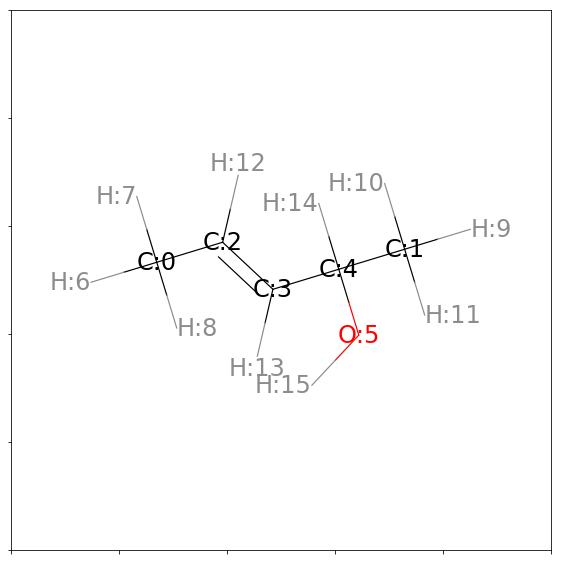

In [78]:
inchi = 'InChI=1S/C5H10O/c1-3-4-5(2)6/h3-6H,1-2H3/b4-3+'
[['A', 5,64],
 ['B', 5.53],
 ['C', 4.23],
 ['D', 1.92],
 ['E', 1.681],
 ['F', 1.240]]
sets = [5.64, 5.53, 4.23, 1.92, 1.681, 1.240]
m = Chem.inchi.MolFromInchi(inchi)
m = Chem.rdmolops.AddHs(m)
m = mol_with_atom_index(m)
Chem.Draw.MolToMPL(m)
AllChem.ComputeGasteigerCharges(m)
nmr = assign_peak_to_H(m, sets)
print(nmr)

In [15]:
def mol_with_atom_index(mol):
    n_atoms = mol.GetNumAtoms()
    for idx in range(n_atoms):
        mol.GetAtomWithIdx(idx).SetProp('molAtomMapNumber', str(mol.GetAtomWithIdx(idx).GetIdx()))
    return mol

def assign_peak_to_H(mol, allowable_set):
    partial_charge = []
    n_atoms = mol.GetNumAtoms()
    for i, atom in enumerate(mol.GetAtoms()):
        pc = [int(i), float(atom.GetProp("_GasteigerCharge"))]
        partial_charge.append(pc)

    partial_charge.sort(key = lambda x: x[1])
    partial_charge.reverse()
    #for i in range(len(partial_charge)):
    #    print ("{0}".format(partial_charge[i]))
    '''now list partial_charge is oriented with the largest value to lowest
       value of the partial charge assigned with its atom number'''
    '''Allowable set is NMR peak data which is sorted from highest ppm to
    lowest ppm, we have to assign each ppm to **several** numbers of protons'''
    nmr_peak = []
    allowable_set_pad = np.zeros(n_atoms)
    allowable_set_pad[0:len(allowable_set)] = allowable_set
    #print(allowable_set_pad)
    nmr_peak.append([partial_charge[0][0],allowable_set_pad[0]])
    
    #partial_charge[i][1] 값을 비교 -> 전꺼와 같으면 같은 값, 다르면 그 다음 값
    j = 0
    for i in range(1,len(partial_charge)):
        if partial_charge[i-1][1] == partial_charge[i][1]:
            nmr_peak.append([partial_charge[i][0], allowable_set_pad[j]])
        elif partial_charge[i-1][1] > partial_charge[i][1]:
            nmr_peak.append([partial_charge[i][0], allowable_set_pad[j+1]])
            j += 1
    
    return nmr_peak

[[15, 5.64], [4, 5.53], [14, 4.23], [13, 1.92], [12, 1.681], [8, 1.24], [7, 1.24], [6, 1.24], [11, 0.0], [10, 0.0], [9, 0.0], [1, 0.0], [0, 0.0], [3, 0.0], [2, 0.0], [5, 0.0]]


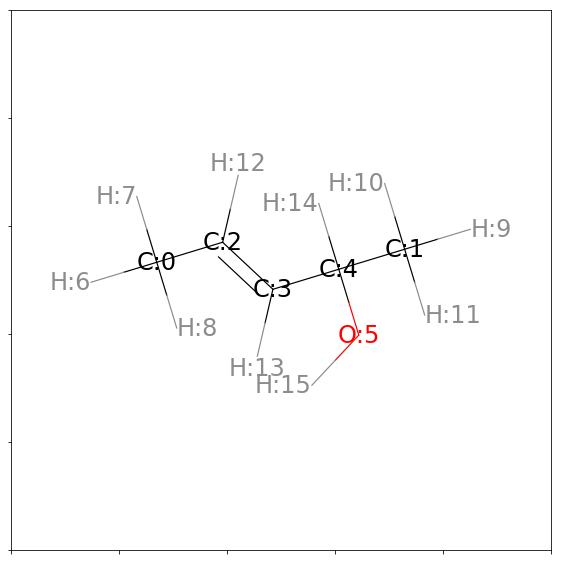

In [16]:
inchi = 'InChI=1S/C5H10O/c1-3-4-5(2)6/h3-6H,1-2H3/b4-3+'
[['A', 5,64],
 ['B', 5.53],
 ['C', 4.23],
 ['D', 1.92],
 ['E', 1.681],
 ['F', 1.240]]
sets = [5.64, 5.53, 4.23, 1.92, 1.681, 1.240]
m = Chem.inchi.MolFromInchi(inchi)
m = Chem.rdmolops.AddHs(m)
m = mol_with_atom_index(m)
Chem.Draw.MolToMPL(m)
AllChem.ComputeGasteigerCharges(m)
nmr = assign_peak_to_H(m, sets)
print(nmr)